# Time Series Analysis of Netflix data

In [1]:
#import packages and upload netflix google trends csv, parsing the dates from the 'Period' column
from fbprophet import Prophet
import pandas as pd 
import numpy as np
import holidays 
from datetime import date 
import matplotlib.pyplot as pyplot 
from statsmodels.tsa import stattools
import seaborn as sns 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
import warnings 
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.pyplot as pyplot
from statsmodels.tsa import seasonal

#read in netflix google trends csv
netflix = pd.read_csv('netflix.googletrends2.csv', parse_dates=['period'])

# Decomposition 

In [2]:
#convert to stationary format acceptable for time series modeling 
netflix['period'] = netflix['period'].dt.date

netflix.set_index('period', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


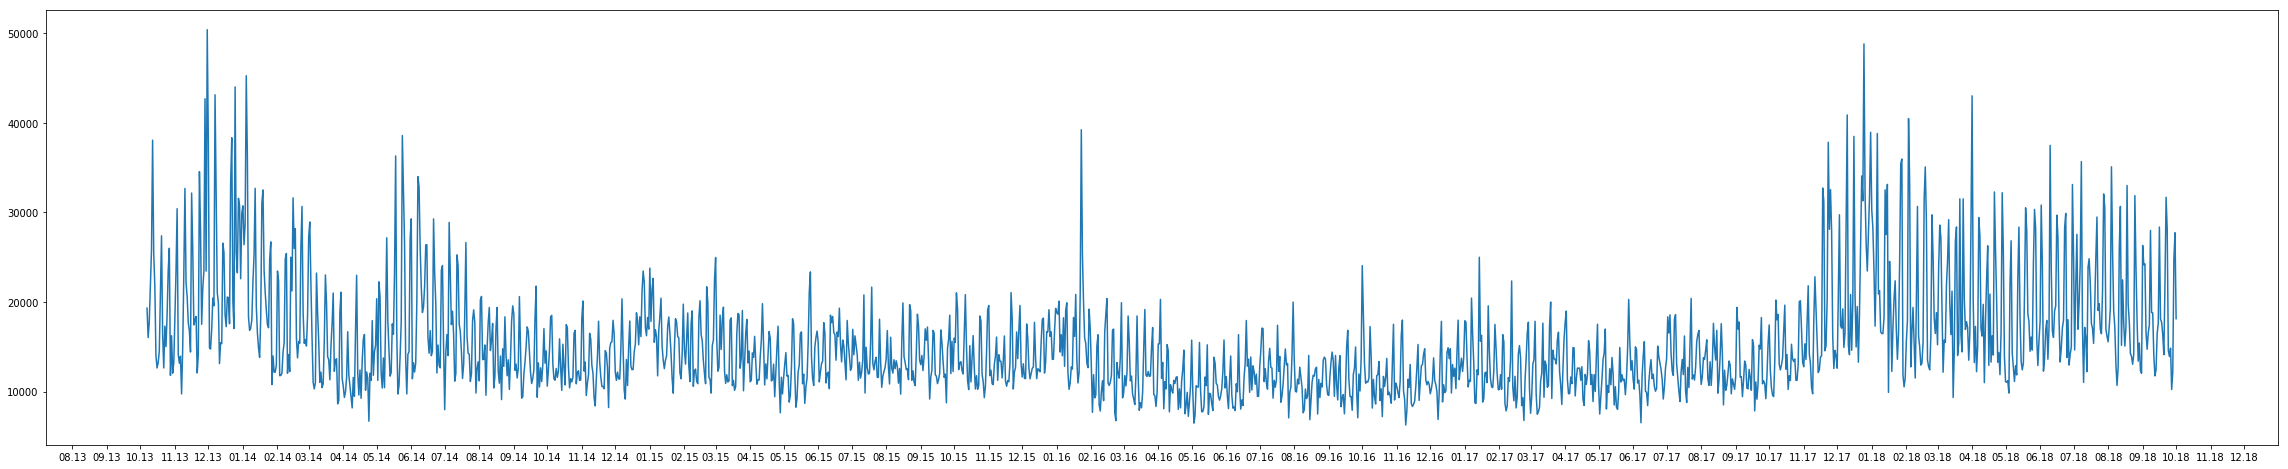

In [3]:
#make chart 
dimensions = (40,8)
fig, ax = pyplot.subplots(figsize = dimensions)
#differentiate year and month
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')
#set parameters
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)
ax.plot(netflix.index, netflix['value'])

The visualization above shows the monthly google trends pattern over a 5 year period. 

In [4]:
#decompose time series data 
decompose_model = seasonal.seasonal_decompose(netflix['value'].tolist(), freq=365, model='additive')
dir(decompose_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend']

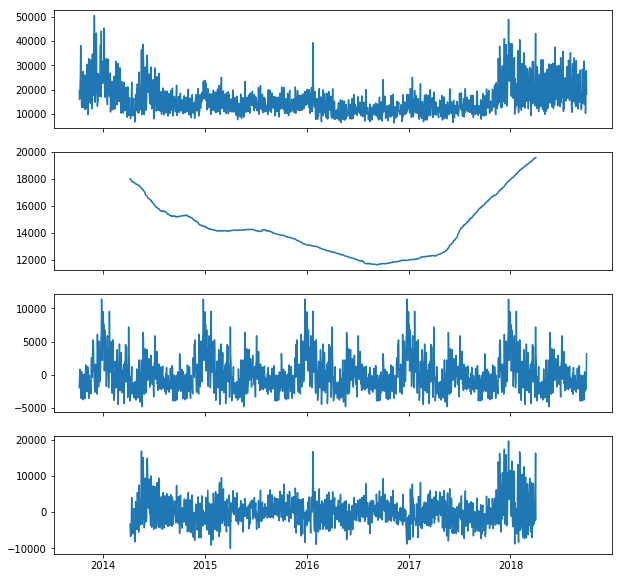

In [5]:
dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex = 'all')
ax1.plot(netflix.index, netflix['value'])
ax2.plot(netflix.index, decompose_model.trend)
ax3.plot(netflix.index, decompose_model.seasonal)
ax4.plot(netflix.index, decompose_model.resid)

What is the overall trend? Is the search interest for your brand steadily growing?

You can see according to the plots above, Netflix google searches steadily declined since the end of 2014 and then showed a significant increase beginning in late 2017 and early 2018. Based off of the plots, the search interest for Netflix is growing. 

In [6]:
#create seasonal column from decomposition
netflix['seasonal'] = decompose_model.seasonal

In [7]:
startdate= pd.to_datetime("2015-01-01").date()
enddate = pd.to_datetime("2015-12-31").date()

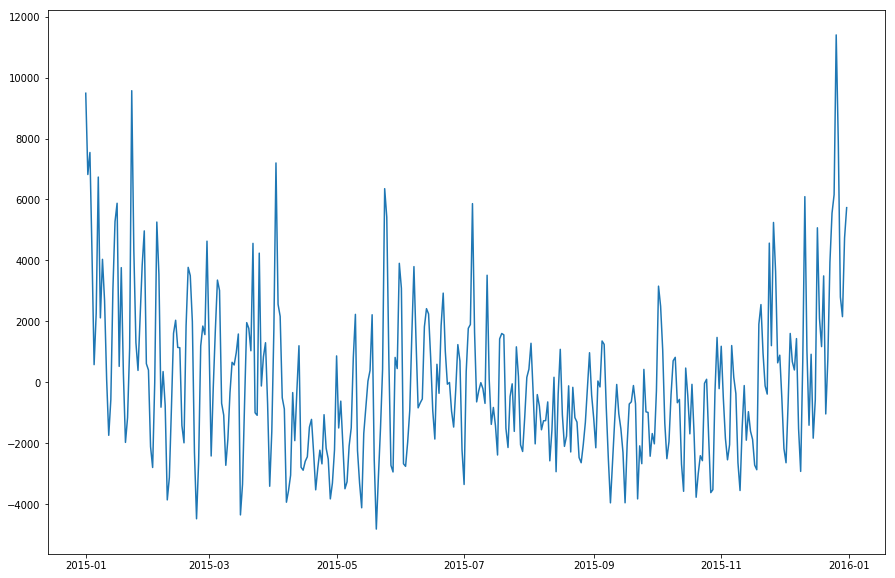

In [8]:
#locate netflix data from start date to end date and plot
oneyear = netflix.loc[startdate:enddate]
dimensions=(15,10)
fig, ax1 = pyplot.subplots(figsize=dimensions)
pyplot.plot(oneyear.index, oneyear.seasonal)

What does the seasonality look like for this brand?
Is the seasonality driven by the product or consumers? 
Why do you think that is?

The plot above shows the Netflix search data plotted according to seasons in 2015. Based off of the plot, there is a significant increase of Netflix searches during January and the very end of December. There are also smaller increases during the summer. Netflix proves to be a very seasonal product according to this plot. The seasonality in this case, is driven by the consumers desire to watch Netflix more often during the summer and winter months. 

# Forecast using Facebook Prophet

In [9]:
#read in data and make the data frame 
netflix = pd.read_csv('netflix.googletrends2.csv', parse_dates=['period'])
prophetdataframe = pd.DataFrame()

In [10]:
#ds = date stamp, timeseries data = y 
prophetdataframe['ds'] = netflix['period']
prophetdataframe['y'] = netflix ['value']

In [11]:
m = Prophet()

In [12]:
#fit the model with prophet 
m.fit(prophetdataframe)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
#predict the next year of data (365 days)
future = m.make_future_dataframe(periods=365)

In [14]:
#use the model to predict 
forecast = m.predict(future)

In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2181,2019-09-27,28901.501964,21263.987242,31030.636317,27772.169294,30110.850533,-2736.100907,-2736.100907,-2736.100907,-1395.781355,-1395.781355,-1395.781355,-1340.319552,-1340.319552,-1340.319552,0.0,0.0,0.0,26165.401057
2182,2019-09-28,28919.550165,27521.842135,37422.258641,27783.286705,30137.742960,3333.698258,3333.698258,3333.698258,4559.402697,4559.402697,4559.402697,-1225.704439,-1225.704439,-1225.704439,0.0,0.0,0.0,32253.248423
2183,2019-09-29,28937.598366,28310.100725,37823.817764,27795.889966,30164.635386,4024.714518,4024.714518,4024.714518,5131.274557,5131.274557,5131.274557,-1106.560039,-1106.560039,-1106.560039,0.0,0.0,0.0,32962.312884
2184,2019-09-30,28955.646567,22425.145545,31941.852808,27808.710714,30190.388381,-1924.045735,-1924.045735,-1924.045735,-938.859165,-938.859165,-938.859165,-985.186571,-985.186571,-985.186571,0.0,0.0,0.0,27031.600832
2185,2019-10-01,28973.694768,20398.048004,30841.014732,27821.687712,30211.879838,-3278.966110,-3278.966110,-3278.966110,-2414.926598,-2414.926598,-2414.926598,-864.039512,-864.039512,-864.039512,0.0,0.0,0.0,25694.728658


A residual plot of the forecast for the next year:

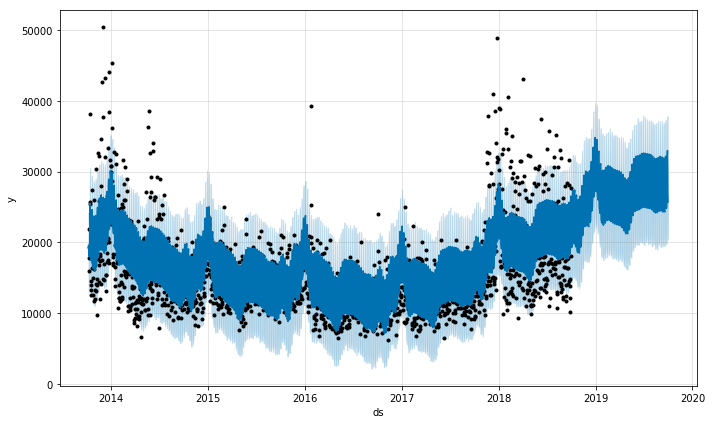

In [16]:
fig1 = m.plot(forecast)

How accurate does the model appear to be?
Are the residuals consistent across time? If not, why do you think it varies?

According to the residual plot above, which includes the predictions for the next 365 days, the residual error is fairly consistent across time. The dark blue represents the error and the light blue shows the error at a 95% confidence interval. Any black dots outside the light blue represent outliers. According to the pattern, there is a large increase at the beginning of January every year. Throughout the year, the next increase is during the Summer months. The model is fairly accurate, with the exception of an increase in outliers around Winter of 2014 and 2018.

Plot of components of the forecast:

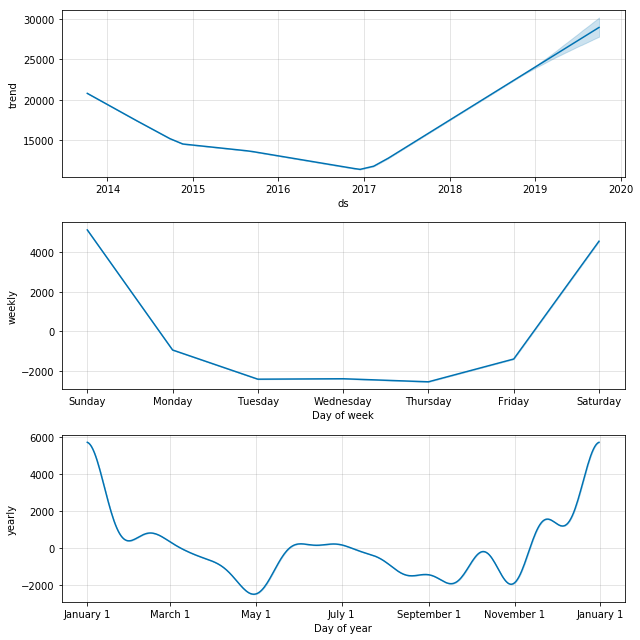

In [17]:
fig2 = m.plot_components(forecast)

Create a graph of the forecast
What are the projected high interest times?
What are the projected low interest times?

The first plot above, showing a general trend, shows an increase in Netflix search starting in 2017, which is consistent with the previous trends. Additionally, in the first plot, the light blue represents the predicted data.  The middle plot, displaying weekly search, shows that there is a large increase in search over the weekend (Friday, Saturday and Sunday, when people are out of work and school). The last plot shows search trends over a year. This is consistent with the residual plot, showing that there is an increase in the winter and a slight increase in the summer months. The lowest time during the week is on Wednesday, which is usually when people are busiest with work and school. 

In [18]:
#find error of prediction model and assign to new data frame 
erroranalysis = m.predict(prophetdataframe)

In [19]:
#predict value for each day
#create column and find error of value from y 
erroranalysis['value'] = prophetdataframe['y']

#create column to find the daily error of reisduals by subtracting the value minus the predicted value for y 
#actual - predicted 
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']

#create column to find error of absolute residuals by taking the absolute value of the error analysis from residuals 
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])
                                        
erroranalysis.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresiduals
0,2013-10-07,20789.035332,14743.923286,24416.236012,20789.035332,20789.035332,-1195.172171,-1195.172171,-1195.172171,-938.859165,...,-256.313006,-256.313006,-256.313006,0.0,0.0,0.0,19593.863161,19308.224940,-285.638221,285.638221
1,2013-10-08,20772.845841,13087.435584,23344.991900,20772.845841,20772.845841,-2629.495667,-2629.495667,-2629.495667,-2414.926598,...,-214.569069,-214.569069,-214.569069,0.0,0.0,0.0,18143.350174,16026.411518,-2116.938656,2116.938656
2,2013-10-09,20756.656351,13063.245400,22913.868515,20756.656351,20756.656351,-2584.738321,-2584.738321,-2584.738321,-2393.288795,...,-191.449526,-191.449526,-191.449526,0.0,0.0,0.0,18171.918029,17788.743393,-383.174636,383.174636
3,2013-10-10,20740.466860,13041.867981,22713.761522,20740.466860,20740.466860,-2735.638902,-2735.638902,-2735.638902,-2547.821341,...,-187.817561,-187.817561,-187.817561,0.0,0.0,0.0,18004.827958,21834.851481,3830.023524,3830.023524
4,2013-10-11,20724.277369,14028.690854,24123.587083,20724.277369,20724.277369,-1599.876821,-1599.876821,-1599.876821,-1395.781355,...,-204.095466,-204.095466,-204.095466,0.0,0.0,0.0,19124.400548,25750.490085,6626.089537,6626.089537


In [20]:
#sum the total error 
totalerror = erroranalysis['absoluteresiduals'].sum()

In [21]:
print(totalerror)

4888381.005244071


In [22]:
#total error divided by number of days, returns an avergae score by day 
print(totalerror/len(erroranalysis))

2684.448657465168


In [23]:
erroranalysis['value'].describe()

count     1821.000000
mean     15316.545856
std       5999.772515
min       6256.339727
25%      11344.725054
50%      13632.472794
75%      17525.483797
max      50410.105214
Name: value, dtype: float64

# Time series with holidays 

In [24]:
#find dates of major US holidays 
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    print(date, name)
    goodholidays.append(name)

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [25]:
#remove holidays that wont have an effect on netflix viewing
goodholidays.remove("Washington's Birthday")
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Columbus Day")



In [26]:
#name of holiday, ds=day, window= add days before or ahead of the date of the holiday (holiday weekends)
sales = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window'])
sales.head()


,holiday,ds,lower_window,upper_window


In [27]:
#add additiondal days/holidays that people are generally watching more netflix

releasedates = pd.DataFrame({
  'holiday': 'newrelease',
  'ds': pd.to_datetime(['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']),
    'lower_window': 0,
      'upper_window': 6,
})
valentines = pd.DataFrame({
    'holiday': 'valentine',
    'ds': pd.to_datetime(['2014-02-14', '2015-02-14', '2016-02-14', '2017-02-14', '2018-02-14']),
    'lower_window': 0,
      'upper_window': 6,
})
halloween = pd.DataFrame({
    'holiday': 'halloween',
    'ds': pd.to_datetime(['2014-10-31', '2015-10-31', '2016-10-31', '2017-10-31', '2018-10-31']),
    'lower_window': 0,
      'upper_window': 6,
})
newholidays = pd.concat((sales, releasedates, valentines, halloween))

In [28]:
#find what day the holiday is on and iterate over all the years 
for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
           # print(dayoftheweek)
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4: #4 is friday
                upper_window = 2   
            newholidays.loc[len(sales)] = [name, date, lower_window, upper_window]
                

In [29]:
sales.head()

,holiday,ds,lower_window,upper_window


In [30]:
#read in csv 
netflix = pd.read_csv('netflix.googletrends2.csv', parse_dates=['period'])


In [31]:
#make data frame 
prophetdataframe = pd.DataFrame()

In [32]:
prophetdataframe['ds'] = netflix['period']
prophetdataframe['y'] = netflix ['value']

In [33]:
#assign m to hold sales during holidays 
m = Prophet(holidays=newholidays)

In [34]:
#add in all US country holidays 
m.add_country_holidays(country_name='US')


In [35]:
#fit the holiday data to the model 
m.fit(prophetdataframe)
print(m.train_holiday_names)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                   Christmas Day
1                      newrelease
2                       valentine
3                       halloween
4                  New Year's Day
5     Martin Luther King, Jr. Day
6           Washington's Birthday
7                    Memorial Day
8                Independence Day
9                       Labor Day
10                   Columbus Day
11                   Veterans Day
12                   Thanksgiving
13       Christmas Day (Observed)
14      New Year's Day (Observed)
15        Veterans Day (Observed)
16    Independence Day (Observed)
dtype: object


In [36]:
#predict future days with holidays 
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

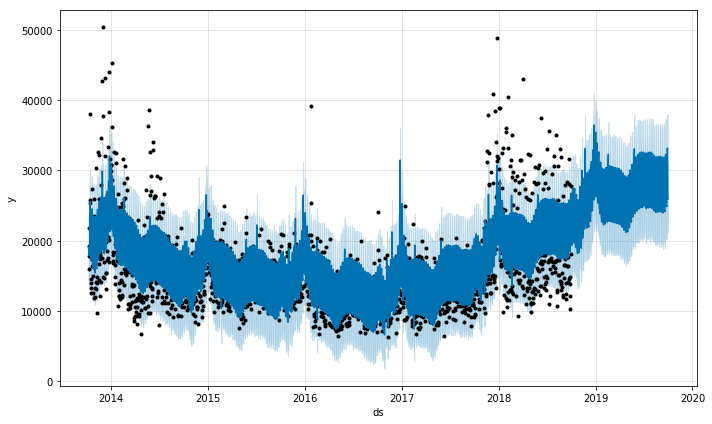

In [37]:
#plot forecast including holidays 
fig1 = m.plot(forecast)

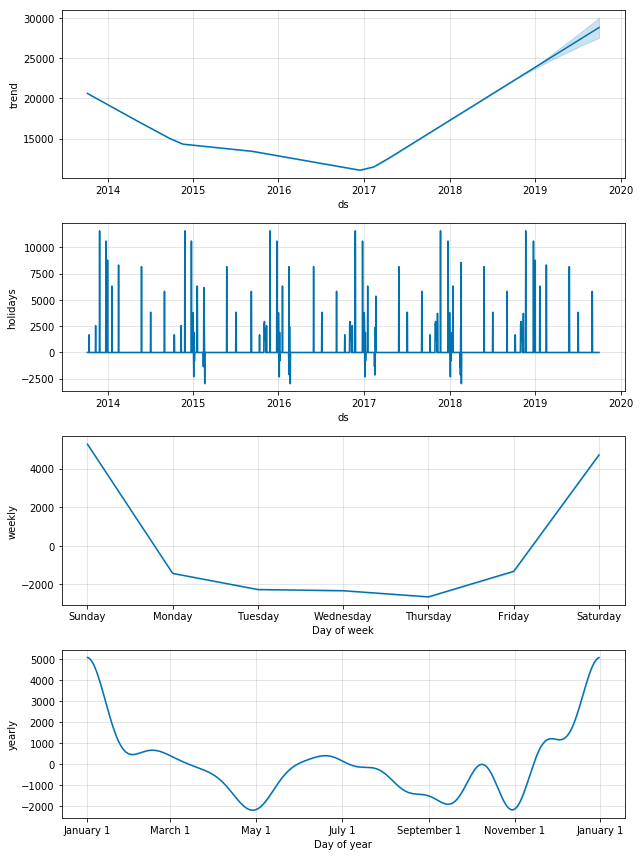

In [38]:
fit = m.plot_components(forecast)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


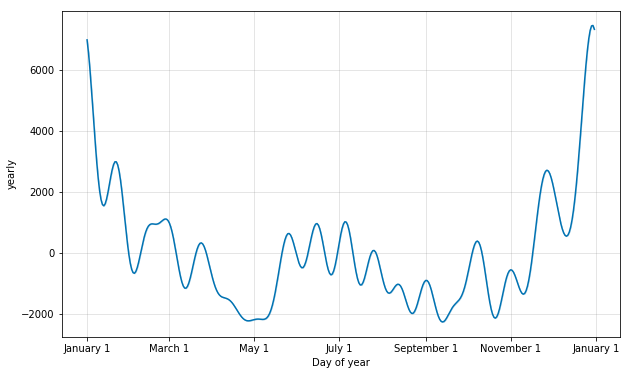

In [39]:
from fbprophet.plot import plot_yearly
#plot year with more seasonalities 
m = Prophet(yearly_seasonality=20).fit(prophetdataframe)
a = plot_yearly(m)

The plot above shows a more in-depth view of seasonality changes 

In [40]:
#export forecasted data to a csv file 
forecast.to_csv('finalforecast.csv')

In [41]:
#calculate error
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])
                      

In [42]:
totalerror = erroranalysis['absoluteresiduals'].sum()

In [43]:
print(totalerror/len(erroranalysis))

2615.251882292531


In [44]:
print(erroranalysis.nlargest(10, 'absoluteresiduals'))

             ds         trend    yhat_lower    yhat_upper   trend_lower  \
1540 2017-12-25  17334.585873  17800.921071  27359.187208  17334.585873   
54   2013-11-30  19896.915459  22116.204141  31613.833623  19896.915459   
52   2013-11-28  19928.693920  15683.930989  24975.751994  19928.693920   
1508 2017-11-23  16757.006320  11679.200590  21147.053563  16757.006320   
79   2013-12-25  19499.684714  18602.413141  27916.888036  19499.684714   
1637 2018-04-01  19085.373893  18598.185696  28071.688983  19085.373893   
838  2016-01-23  12926.406707  15842.955918  25082.879665  12926.406707   
1580 2018-02-03  18056.560315  17277.934668  27020.399604  18056.560315   
1525 2017-12-10  17063.845458  18146.904068  27614.184789  17063.845458   
61   2013-12-07  19785.690849  20312.408202  29984.760912  19785.690849   

       trend_upper  additive_terms  additive_terms_lower  \
1540  17334.585873     5227.152821           5227.152821   
54    19896.915459     7022.259290           7022.2592

In [45]:
date = pd.to_datetime("2015-02-02")
theindex = prophetdataframe[prophetdataframe.ds == date].index

In [46]:
print(theindex)

Int64Index([483], dtype='int64')


In [47]:
prophetdataframe = prophetdataframe.drop(theindex)

# Netflix adspend data 

In [48]:
#upload netflix adspend data 
adspend = pd.read_csv('netflix.adspend.csv')

In [49]:
#use a regular expression to change the time period to say week of "date"
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF", "", regex=True)

In [50]:
#format time period with regular expression 
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "", regex=True)

In [51]:
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "", regex=True)

In [52]:
list(adspend)

['TIME PERIOD',
 'PRODUCT',
 'TOTAL',
 'NETWORK TV',
 'CABLE TV',
 'SYNDICATION',
 'SPOT TV',
 'MAGAZINES',
 'SUNDAY MAGS',
 'NATL NEWSP',
 'NEWSPAPER',
 'NETWORK RADIO',
 'NAT SPOT RADIO',
 'OUTDOOR']

In [53]:
#change time period to a fixed time 
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])

In [54]:
#pivot the data 
adspendnoproducts = adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

In [55]:
list(adspendnoproducts)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SUNDAY MAGS',
 'SYNDICATION',
 'TOTAL']

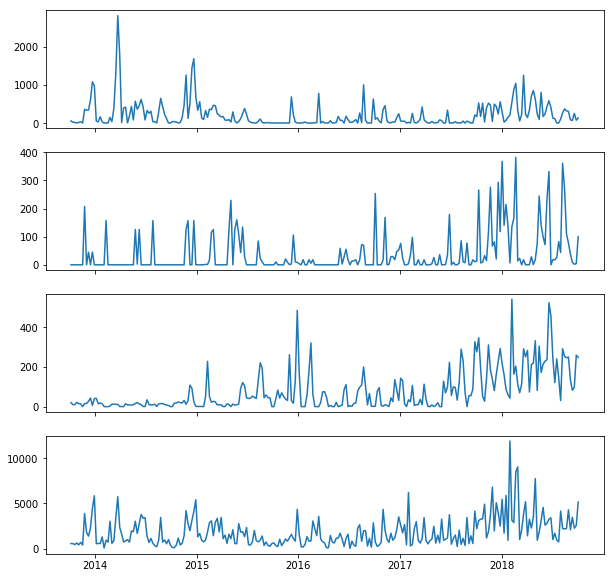

In [56]:
#plot adspend no products with specific ad platforms 

dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all')

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV'])
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

Do any advertising expenditures drive Google search interest?
If so, which ones?
Why do you think that is?
If not, why do you think they fail to do so.

Looking at the plots above, the most ad spending goes towards cable TV. You can see from the first plot, that the highest ad spend was in 2014, and was spent on cable TV. According to outside research, Netflix launched a "watch together" tv ad campaign in 2014, that could be reponsible for a lot of the cable TV ad expenditure in that year. The plot that represents spot TV, shows two increases in expenditure. The first is in 2016, meaning Netflix spent significantly more during this year on their spot TV campaigns, the next increase is around 2018. 

In [57]:
testdate = pd.to_datetime("2013-10-07")

In [58]:
testdate.weekday()

0

In [59]:
netflix.set_index('period', inplace=True)

In [60]:
netflixweekly = netflix.resample('W-MON', closed='left', label='left').mean()

In [61]:
netflixweekly.head()

,Unnamed: 0,value,onedifvalue
period,,,
2013-10-07,3,23457.020431,1018.570843
2013-10-14,10,17753.545894,280.906445
2013-10-21,17,18487.245031,-197.779320
2013-10-28,24,17943.188912,631.200712
2013-11-04,31,17391.512002,322.937350


In [62]:
#merge weekly data and adspend no products data 
mergedweeklydata = adspendnoproducts.join(netflixweekly)

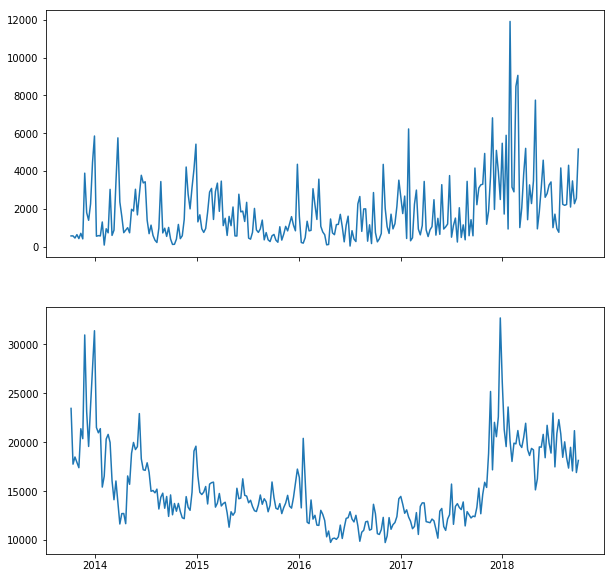

In [63]:
#plot the total and the value from the merged data

dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize=dimensions, sharex='all')

ax1.plot(mergedweeklydata.index, mergedweeklydata['TOTAL'])
ax2.plot(mergedweeklydata.index, mergedweeklydata['value'])

The visualizations above show the overlay of ad spend and google search interest. The two plots visually align for the most part. The top plot represents the merged adspend data, and the bottom plot represents the merged search data. The one section that does not align is the search data in 2014, compared to ad spend, where the search data is very high. 

In [64]:
#find correlation between value and total 
mergedweeklydata['TOTAL'].corr(mergedweeklydata['value'])

0.37530075786198763

In [65]:
#difference of total and value 
mergedweeklydata['TOTALdiff'] = mergedweeklydata['TOTAL'].diff(1)
mergedweeklydata['valuediff'] = mergedweeklydata['value'].diff(1)

In [66]:
#correlation of the difference 
mergedweeklydata['TOTALdiff'].corr(mergedweeklydata['valuediff'])

0.040049557353390934

In [67]:
#download merged data to csv 
mergedweeklydata.to_csv('finaladspend.googletrends.weekly.csv')

In [68]:
#import csv of merged data 
adspend_trends = pd.read_csv('finaladspend.googletrends.weekly.csv', parse_dates=['FIXED TIME'])

In [69]:
adspend_trends.set_index('FIXED TIME', inplace=True)

In [70]:
adspend_trends = adspend_trends.drop(columns=['onedifvalue', 'Unnamed: 0', 'TOTALdiff','valuediff'])

In [71]:
list(adspend_trends)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SUNDAY MAGS',
 'SYNDICATION',
 'TOTAL',
 'value']

In [72]:
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print(adf_result[1])

4.944569609526588e-09
0.06237188986361679
0.6888967165130822
0.5507690801310768
0.9967319472189904
5.200387873510148e-06
0.09667874305370416
0.7976617760666814
0.34853519025821755
4.858038849581863e-29
0.2744078405823607
0.24171083022075313
0.04214003791135942


In [73]:
#add diff to data frame 
adspend_trends_diff=pd.DataFrame()

In [74]:
#loop through adspend trends and rename values with "2_diff" at the end of the original name 
for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)

In [75]:
adspend_trends_diff.head()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SUNDAY MAGS_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,-33.3,0.0,0.0,0.0,0.0,-105.7,0.0,0.0,-10.1,0.0,150.3,1.2,-5703.474537
2013-10-21,-7.2,0.0,0.0,0.0,0.0,28.6,0.0,0.0,0.6,0.0,-134.4,-112.4,733.699138
2013-10-28,-10.4,0.0,0.0,0.0,0.0,-101.1,0.0,233.0,11.2,0.0,47.0,179.8,-544.056119
2013-11-04,9.3,0.0,0.0,0.0,0.0,131.2,0.0,-233.0,-6.4,0.0,-110.8,-209.8,-551.676910


In [76]:
#loop through acolumn to calcuate adf result and print it 
for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    print(adf_result[1])

2.737565394693417e-16
2.834615515519561e-14
8.44449296505387e-15
5.2624941219073705e-12
6.799586104486564e-06
4.097629531847151e-13
2.9107116033648535e-12
1.3630246836291944e-15
3.5528864600703405e-20
1.507821040229618e-13
1.8385816673648825e-17
7.158438380058312e-05
3.768298615505549e-24


In [77]:
#loop through value diff and add the correlated value is there is no value in the column
correlationlist= []
for acolumn in list(adspend_trends_diff):
    if"value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value_diff'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV_diff 0.15330481351407518
MAGAZINES_diff -0.0645117032717335
NAT SPOT RADIO_diff 0.038105939267950695
NATL NEWSP_diff 0.07982000659399369
NETWORK RADIO_diff -0.03518815512017371
NETWORK TV_diff 0.004476830229893471
NEWSPAPER_diff 0.18035948266881777
OUTDOOR_diff 0.015154416994080747
SPOT TV_diff -0.03102113204694213
SUNDAY MAGS_diff 0.11671475336285524
SYNDICATION_diff 0.05866147109698825
TOTAL_diff 0.04004955735339096


This list shows how the variables are related and any correlation between them. 

In [78]:
#mean of correlated list 
np.mean(correlationlist)

0.046327190053599726

In [79]:
#loop through value and add the correlated value is there is no value in the column
correlationlist= []
for acolumn in list(adspend_trends):
    if"value" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends['value'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV 0.27321830046340906
MAGAZINES 0.1670298979313202
NAT SPOT RADIO 0.5536188076823668
NATL NEWSP 0.31854538265257437
NETWORK RADIO 0.39833471378490837
NETWORK TV 0.19410432734746316
NEWSPAPER 0.35553142861783177
OUTDOOR 0.09050770942541671
SPOT TV 0.283194488843975
SUNDAY MAGS 0.10350383391975007
SYNDICATION 0.1878083162354102
TOTAL 0.3753007578619877


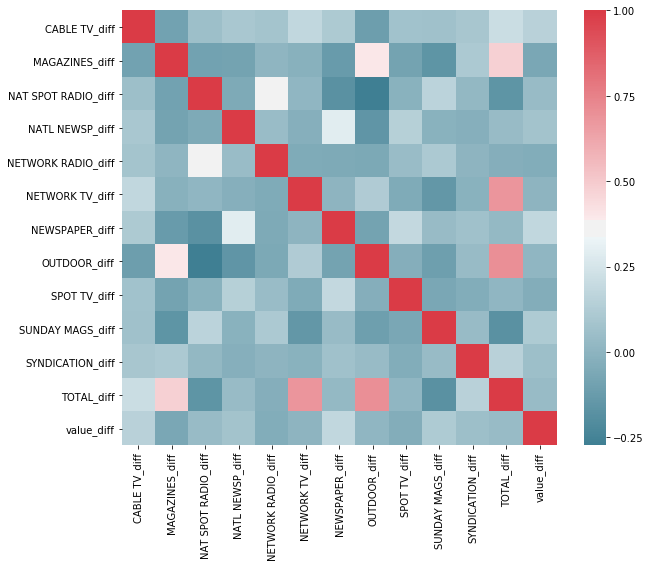

In [80]:
#assign f, ax, and corr and map the values on a heat map 
f, ax = pyplot.subplots(figsize=(10,8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True),
           square=True, ax=ax)

In [81]:
#calcluate the significant lags between value and value diff 
numofweeks = 8
significantlags =[]
for acolumn in list(adspend_trends_diff): 
    if 'value' not in acolumn: 
        testframe = adspend_trends_diff[['value_diff', acolumn]]  
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose=False)
        for week in range(1, numofweeks+1): 
            if results[week][0]['params_ftest'][1] < 0.05: 
                print('%s is significant at %s weeks' % (acolumn, week))
                significantlags.append(week)

NAT SPOT RADIO_diff is significant at 3 weeks
NAT SPOT RADIO_diff is significant at 4 weeks
NAT SPOT RADIO_diff is significant at 5 weeks
NAT SPOT RADIO_diff is significant at 6 weeks
NAT SPOT RADIO_diff is significant at 7 weeks
NAT SPOT RADIO_diff is significant at 8 weeks
NEWSPAPER_diff is significant at 6 weeks
NEWSPAPER_diff is significant at 7 weeks
NEWSPAPER_diff is significant at 8 weeks
OUTDOOR_diff is significant at 2 weeks
SUNDAY MAGS_diff is significant at 2 weeks
SUNDAY MAGS_diff is significant at 3 weeks
SUNDAY MAGS_diff is significant at 4 weeks
SUNDAY MAGS_diff is significant at 5 weeks
SUNDAY MAGS_diff is significant at 6 weeks
SUNDAY MAGS_diff is significant at 7 weeks
SUNDAY MAGS_diff is significant at 8 weeks


In [82]:
#assign adpsend trends diff
modelingdataset = adspend_trends_diff

In [83]:
modelingdataset.tail()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SUNDAY MAGS_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,,
2018-09-03,-220.6,-645.5,49.3,0.0,-71.7,1342.4,-39.3,-2511.7,-114.9,0.0,0.0,-2212.0,2122.492879
2018-09-10,-18.3,782.7,0.0,727.9,0.0,-28.2,-28.5,0.0,-51.9,0.0,0.0,1383.7,-2414.528821
2018-09-17,187.1,-259.4,0.0,-94.7,0.0,-1051.6,-7.8,0.0,14.0,0.0,7.3,-1205.2,4118.502027
2018-09-24,-180.5,-98.6,0.0,-595.5,0.0,943.4,2.7,0.0,162.2,0.0,56.7,290.4,-4282.641245
2018-10-01,59.1,470.5,-50.7,416.2,0.0,-1078.4,95.6,2763.9,-11.3,0.0,-64.0,2600.7,1235.439845


In [84]:
date = pd.to_datetime('2018-10-08')
modelingdataset.loc[date] = np.nan

In [85]:
date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan

In [86]:
#loop through acolumn in the modeling data set to find lags 1-3 and rename column 
for acolumn in list(modelingdataset):
    if 'value' not in acolumn:
        for alag in range(1,3):
            columnname = '%s_lag%s' % (acolumn, alag)
            modelingdataset[columnname] = modelingdataset[acolumn].shift(alag)

In [87]:
modelingdataset.sort_index(axis=1, inplace=True)
modelingdataset.head()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,MAGAZINES_diff,MAGAZINES_diff_lag1,MAGAZINES_diff_lag2,NAT SPOT RADIO_diff,NAT SPOT RADIO_diff_lag1,NAT SPOT RADIO_diff_lag2,NATL NEWSP_diff,...,SUNDAY MAGS_diff,SUNDAY MAGS_diff_lag1,SUNDAY MAGS_diff_lag2,SYNDICATION_diff,SYNDICATION_diff_lag1,SYNDICATION_diff_lag2,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,-33.3,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,150.3,NaN,NaN,1.2,NaN,NaN,-5703.474537
2013-10-21,-7.2,-33.3,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,NaN,-134.4,150.3,NaN,-112.4,1.2,NaN,733.699138
2013-10-28,-10.4,-7.2,-33.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.0,-134.4,150.3,179.8,-112.4,1.2,-544.056119
2013-11-04,9.3,-10.4,-7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-110.8,47.0,-134.4,-209.8,179.8,-112.4,-551.676910


In [88]:
#export to csv 
modelingdataset.to_csv('finalgoogle_adspend_differenced_lagged_fordatarobot.csv')

In [89]:
alldata = pd.read_csv("finalgoogle_adspend_differenced_lagged_fordatarobot.csv")

In [90]:
alldata.set_index(alldata['FIXED TIME'], inplace=True)

In [91]:
alldata= alldata.drop(columns=['FIXED TIME'])

In [92]:
#taking off first 6 rows to remove NA's
alldata = alldata.iloc[6:]

In [93]:
alldata.tail()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,MAGAZINES_diff,MAGAZINES_diff_lag1,MAGAZINES_diff_lag2,NAT SPOT RADIO_diff,NAT SPOT RADIO_diff_lag1,NAT SPOT RADIO_diff_lag2,NATL NEWSP_diff,...,SUNDAY MAGS_diff,SUNDAY MAGS_diff_lag1,SUNDAY MAGS_diff_lag2,SYNDICATION_diff,SYNDICATION_diff_lag1,SYNDICATION_diff_lag2,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2018-09-17,187.1,-18.3,-220.6,-259.4,782.7,-645.5,0.0,0.0,49.3,-94.7,...,0.0,0.0,0.0,7.3,0.0,0.0,-1205.2,1383.7,-2212.0,4118.502027
2018-09-24,-180.5,187.1,-18.3,-98.6,-259.4,782.7,0.0,0.0,0.0,-595.5,...,0.0,0.0,0.0,56.7,7.3,0.0,290.4,-1205.2,1383.7,-4282.641245
2018-10-01,59.1,-180.5,187.1,470.5,-98.6,-259.4,-50.7,0.0,0.0,416.2,...,0.0,0.0,0.0,-64.0,56.7,7.3,2600.7,290.4,-1205.2,1235.439845
2018-10-08,NaN,59.1,-180.5,NaN,470.5,-98.6,NaN,-50.7,0.0,NaN,...,NaN,0.0,0.0,NaN,-64.0,56.7,NaN,2600.7,290.4,NaN
2018-10-15,NaN,NaN,59.1,NaN,NaN,470.5,NaN,NaN,-50.7,NaN,...,NaN,NaN,0.0,NaN,NaN,-64.0,NaN,NaN,2600.7,NaN


In [94]:
#taking off last 4 rows to remove NA's  
alldata = alldata.iloc[:-4]

In [95]:
#loop through a varible in the data, if no value, append list of all predictors 
listofallpredictors = []
for avar in list(alldata):
    if "value" not in avar:
        listofallpredictors.append(avar)

In [96]:
predictors = alldata[listofallpredictors]

In [97]:
#asign value diff to target 
target = alldata['value_diff']
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size=0.3, random_state=123)

In [98]:
#set CV
model = LassoLarsCV(cv=10, precompute=False)

In [99]:
#fit the model
model = model.fit(pred_train.values, tar_train.values)

In [100]:
#assign predictors from the model to the dataframe 
predictors_model = pd.DataFrame(listofallpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = model.coef_

In [101]:
for index, row in predictors_model.iterrows():
    if row['coeff'] >0:
        print(row.values)

In [102]:
#calulate mean square error of the training set prediction 
train_error= mean_squared_error(tar_train, model.predict(pred_train))
print('training data MSE')
print(train_error)

training data MSE
6007136.774239766


In [103]:
#calulate mean square error of the test set prediction 
test_error= mean_squared_error(tar_test, model.predict(pred_test))
print('test data MSE')
print(test_error)

test data MSE
4101366.53878166


In [104]:
#find r square of training data 
rsquared_train = model.score(pred_train, tar_train)
print('training data r-square')
print(rsquared_train)

training data r-square
0.03705665641270561


In [105]:
#find r square of testing data
rsquared_test = model.score(pred_test, tar_test)
print('test data r-square')
print(rsquared_test)

test data r-square
-0.07091001804688912
